In [1]:
from main import RF
from mmdit import MMDiT
import torch

rf = RF(
    MMDiT(
        in_channels=4,
        out_channels=4,
        dim=2560,
        global_conddim=2560,
        n_layers=28,
        n_heads=8,
        cond_seq_dim=2048,
    ),
    True,
).cuda()
rf.load_state_dict(torch.load("/home/ubuntu/ckpts/model_32769/ema1.pt", map_location="cpu"), strict = False)


/home/ubuntu/py39cuda/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2024-05-25 02:55:27,242] [INFO] [real_accelerator.py:203:get_accelerator] Setting ds_accelerator to cuda (auto detect)
 [WARNING]  async_io requires the dev libaio .so object and headers but these were not found.
 [WARNING]  async_io: please install the libaio-dev package with apt
 [WARNING]  If libaio is already installed (perhaps from source), try setting the CFLAGS and LDFLAGS environment variables to where it can be found.
 [WARNING]  Please specify the CUTLASS repo directory as environment variable $CUTLASS_PATH


/usr/bin/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status


 [WARNING]  sparse_attn requires a torch version >= 1.5 and < 2.0 but detected 2.3
 [WARNING]  using untested triton version (2.3.0), only 1.0.0 is known to be compatible


<All keys matched successfully>

In [2]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from diffusers.image_processor import VaeImageProcessor
from diffusers.models import AutoencoderKL
import os

os.environ['HF_HUB_ENABLE_HF_TRANSFER'] = str(True)

device = 'cuda:0'
t5tokenizer = AutoTokenizer.from_pretrained("EleutherAI/pile-t5-xl", use_fast=True)
t5tokenizer.pad_token = t5tokenizer.bos_token
t5model = AutoModelForSeq2SeqLM.from_pretrained("EleutherAI/pile-t5-xl")
t5model = t5model.to(device).eval()


vae = AutoencoderKL.from_pretrained("stabilityai/sdxl-vae").to("cuda:0")
#rf.model.extend_pe((32, 32), (64, 64))

Loading checkpoint shards: 100%|██████████| 3/3 [00:06<00:00,  2.24s/it]
Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
/home/ubuntu/py39cuda/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [3]:

@torch.no_grad()
def make_cond(cond_prompts, uncond_prompts = None,):
    if not isinstance(uncond_prompts, list):
        uncond_prompts = ["watermark, jpeg, sketch, artifects"] * len(cond_prompts)
        
    allprompts = cond_prompts + uncond_prompts

    t5_inputs = t5tokenizer(
        allprompts,
        truncation=True,
        max_length=77 * 3,
        padding="max_length",    
        return_tensors="pt",
    )
    t5_inputs = {k: v.to(device) for k, v in t5_inputs.items()}
    t5_outputs = t5model.encoder(**t5_inputs)[0] # B, T, D
    # mask that by 0 for padding tokens
    mask = t5_inputs["attention_mask"].unsqueeze(-1).expand(t5_outputs.shape)
    t5_outputs = t5_outputs * mask

    return {'c_seq': t5_outputs[:len(cond_prompts)]}, {'c_seq': t5_outputs[len(cond_prompts):]}


captions = [
    "photo of beautiful flamingo, reading a open book. a big stack of books is piled up next to it",
    "a painting of black and white with a beautiful red flower in the right corner.",
     "photo of mystical blue cat god, dark ancient being, cinematic, 4K, magnificent",
     "beautiful oil painting of a steamboat in a river in the afternoon. On the side of the river is a large brick building",
     "Anime illustration of a kangaroo holding a sign that says \"Starry Night\", in front of the Sydney Opera House sitting next to the Eiffel Tower under a blue night sky of roiling energy, exploding yellow stars, and radiating swirls of blu",
    "A shiny VW van in front of a cityscape. A smiling sloth stands on grass in front of the van and is wearing a leather jacket, a cowboy hat, a kilt and a bowtie. The sloth is holding a quarterstaff and a big book. High-contrast oil painting.",
    "A shiny robot wearing a race car suit and black visor stands proudly in front of an F1 race car. The sun is setting on a cityscape in the background. comic book illustration.",
    "A photo of a light bulb in outer space traveling the galaxy with a sailing boat inside the light bulb.",
    "A sloth in a go kart on a race track. The sloth is holding a banana in one hand. There is a banana peel on the track in the background.",
    # "A raccoon wearing formal clothes, wearing a tophat and holding a cane. The raccoon is holding a garbage bag. Oil painting in the style of traditional Chinese painting.",
    # "a statue of Abraham Lincoln wearing an opaque and shiny astronaut's helmet. The statue sits on the moon, with the planet Earth in the sky.",
    # "the words 'KEEP OFF THE GRASS' on a sign next to a lawn",
     ]
conds, unconds = make_cond(captions)


In [4]:
#
STEPSIZE = 50
L = len(conds['c_seq'])

init_noise = torch.randn(L, 4, 32, 32).cuda()
import math
rat = math.sqrt(1)
images = rf.sample_with_xps_tff(init_noise, conds, null_cond = unconds, sample_steps = STEPSIZE, cfg = 9.5, tff = lambda t : (rat * t / (1 + (rat - 1) *t)))

In [5]:
images_for_grid = [[] for _ in range(L)]

for i, _ in enumerate(conds['c_seq'][:L]):
    for t in range(STEPSIZE):
        x = vae.decode(images[t][i : i + 1].cuda()/0.13025).sample
        img = VaeImageProcessor().postprocess(
            image=x.detach(), do_denormalize=[True, True]
        )[0]
        images_for_grid[i].append(img)

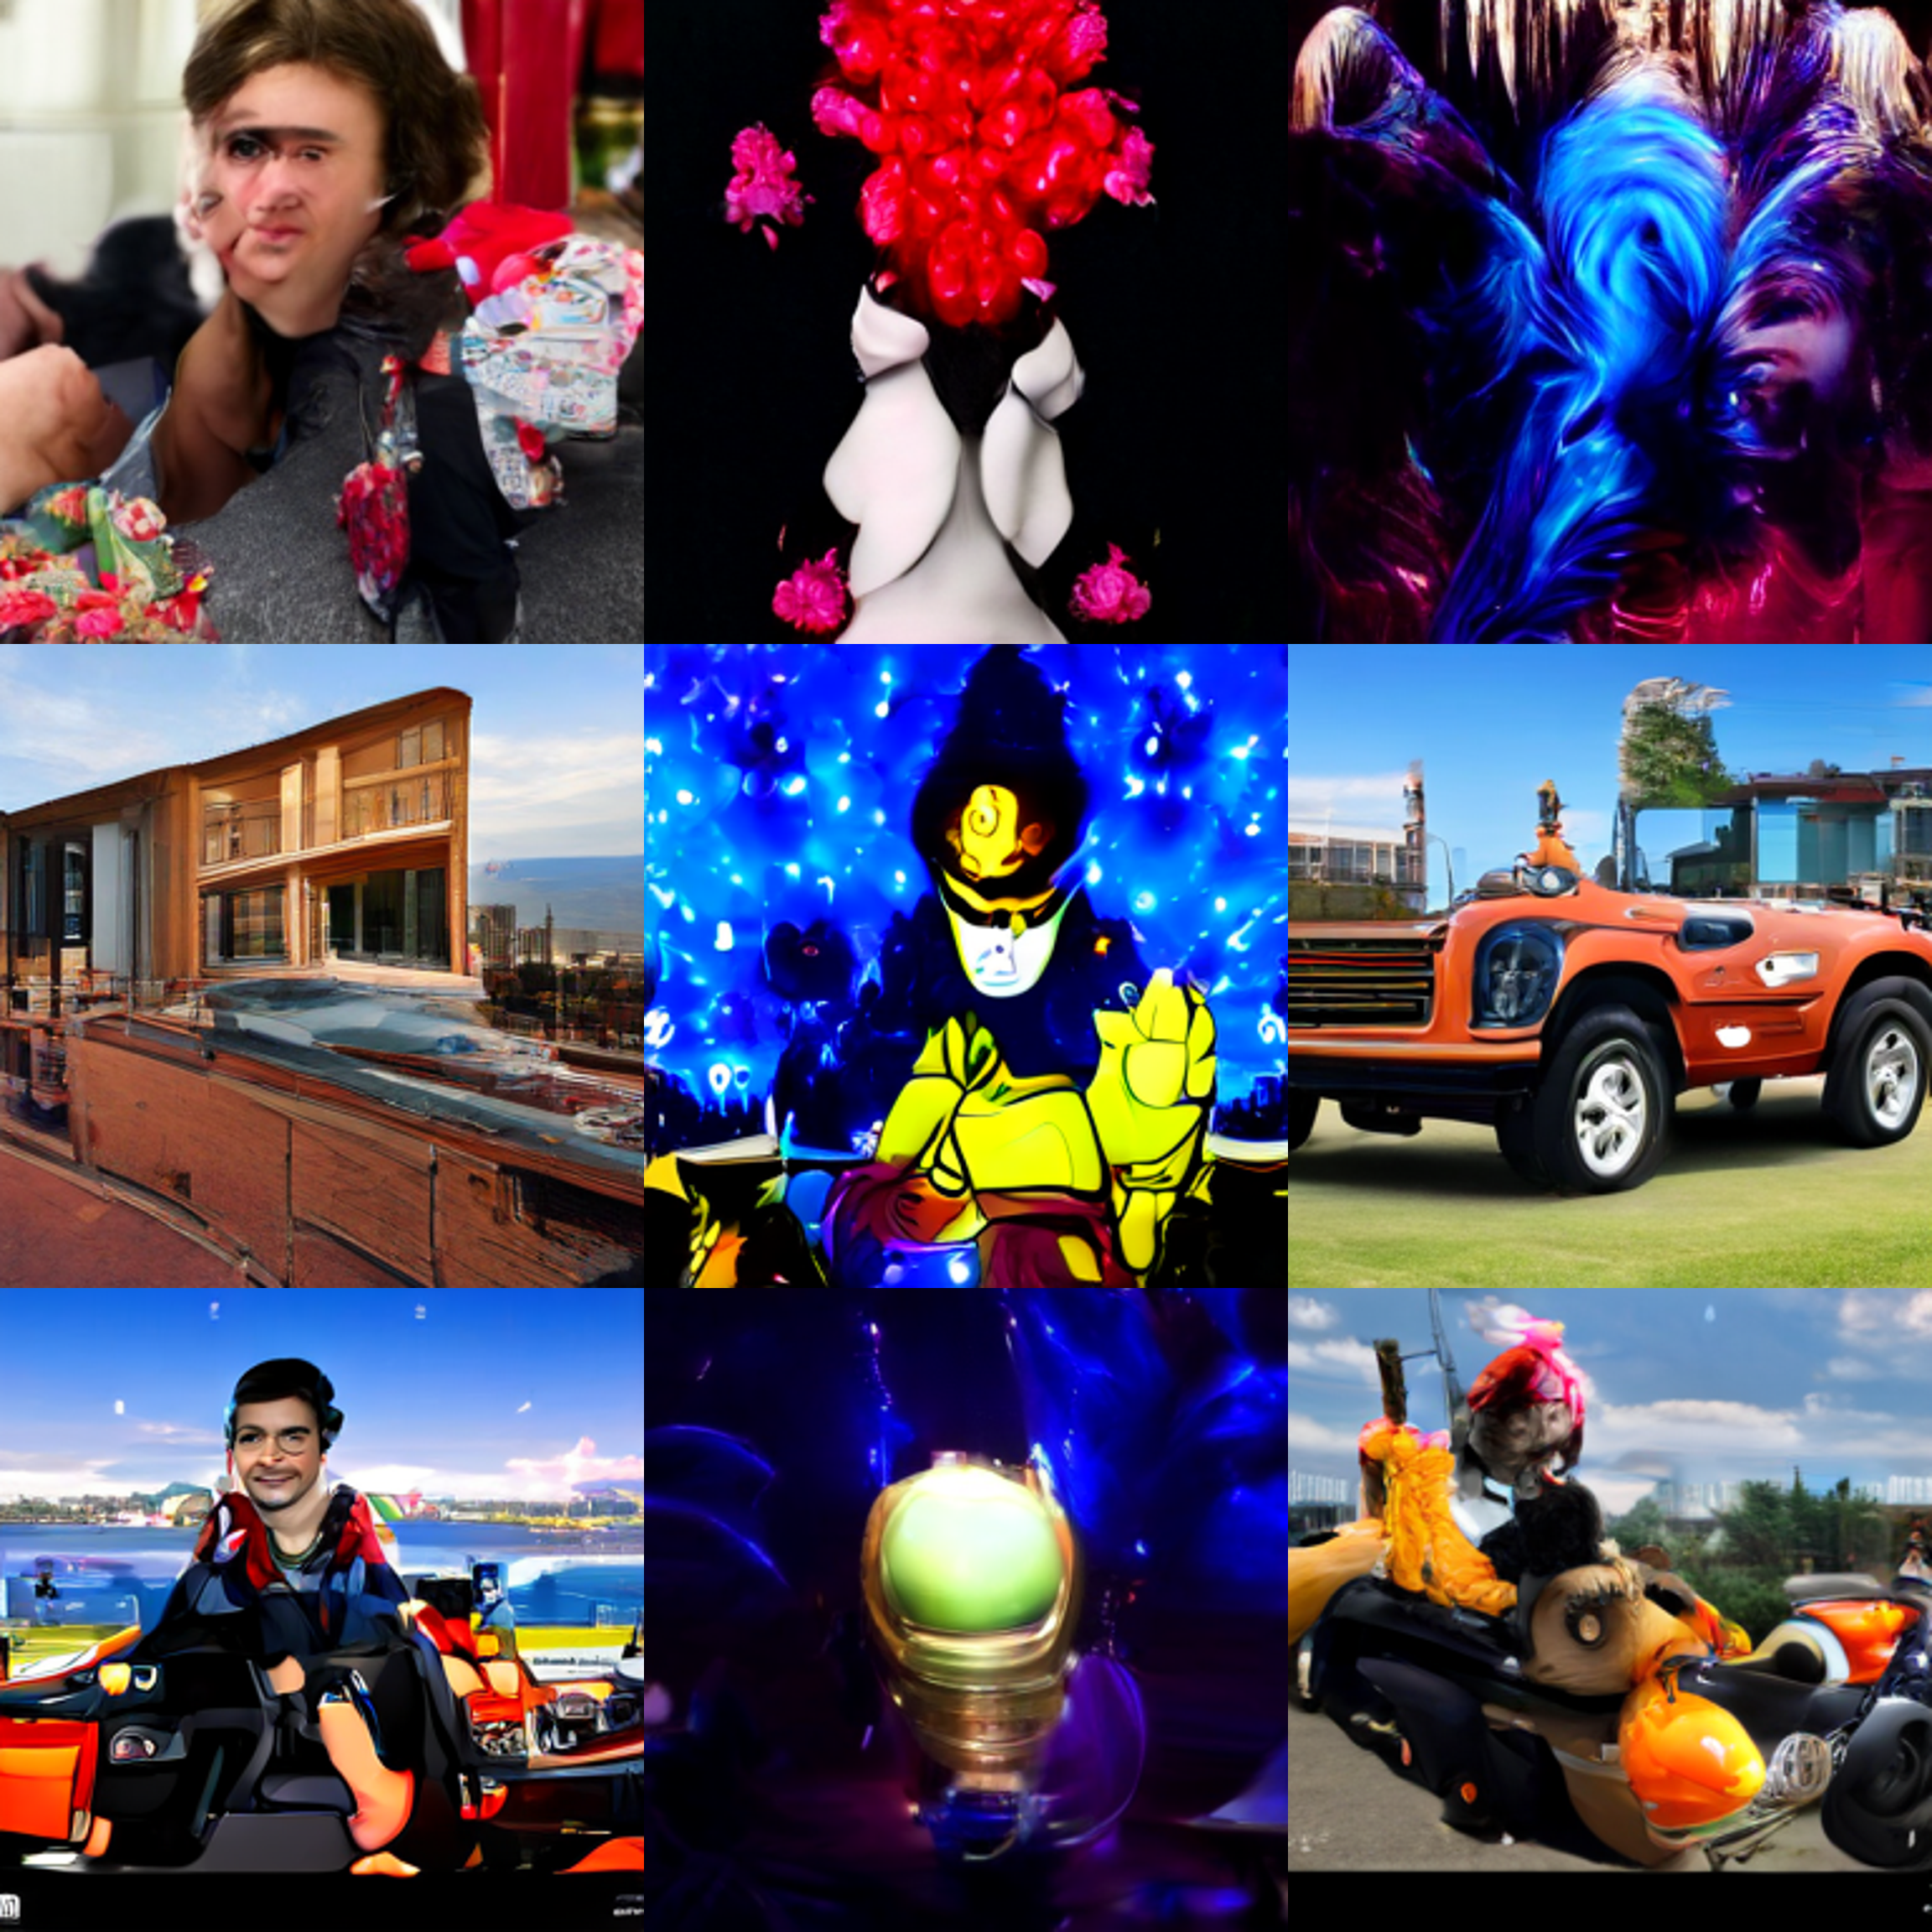

In [6]:
import PIL.Image as Image
import PIL.ImageDraw as ImageDraw
import PIL.ImageFont as ImageFont
import math

def add_caption(image, caption, font=None):
    draw = ImageDraw.Draw(image)
    width, height = image.size
    text_width, text_height = 40, 40
    text_x = 10
    text_y = height - 3 * text_height - 10  # Slightly above the bottom of the image
    draw.text((text_x, text_y), caption[:35], fill="white", font=font)
    draw.text((text_x, text_y + text_height + 5), caption[35:70], fill="white", font=font)
    draw.text((text_x, text_y + text_height * 2 + 5), caption[70:], fill="white", font=font)
    

grid_images = []
sL = math.ceil(math.sqrt(L))
show_captions = [f"{c}" for i, c in enumerate(captions)]

# Load a font
try:
    font = ImageFont.truetype("arial.ttf", 40)
except IOError:
    font = ImageFont.load_default(40)

IW = 768
IH = 768

for t in range(STEPSIZE):
    grid = Image.new('RGB', (IW * sL, IH * sL))
    for i in range(L):
        img = images_for_grid[i][t].copy()
        # append bit of whitespace on the img
        ni = Image.new('RGB', (IW, IH))
        img = img.resize((IW, IW))
        ni.paste(img, (0, 0))
        img = ni

        #add_caption(img, show_captions[i], font=font)
        grid.paste(img, (IW * (i % sL), IH * (i // sL)))
    grid_images.append(grid)

# Make it a gif and make the last image longer
grid_images += [grid_images[-1]] * 15

# Display the last image
grid_images[-1]

In [7]:
grid_images[-1].save('output_3_stage_2.gif', save_all=True, append_images=grid_images[:-1], duration=100, loop=0)
# 
# ffmpeg -i output_3_stage_2.gif -c:v libx264 -crf 23 -pix_fmt yuv420p output_3_stage2.mp4